# Multivariate simulation

> **Note** This notebook is inspired from the notebook [ex_deesse_08_multivariate_sim.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_08_multivariate_sim.ipynb), by Julien Straubhaar.

MPS can be used to simulate more than one variable at at the same time. This is very useful to integrate some "secondary" or "auxiliary" information coming from some geophysical survey, for example. Overall, the features and the connected structures contained in the training image (TI) are better reproduced when two (or more) variables are simulated at the same time.

For example, suppose that you have a categorical TI of the facies distribution in space of some sediments. By using the Maxwell equations, or the law of propagation of seismic waves in that sediments, you can obtain (with *forward modelling*), on the same grid of your categorical variable TI, a map of the electrical resistivity (or changeability, or acoustic impedence...). Therefore, in the end, you can have a bi-variate (multi-variate, more in general) training image.

On the other side, on the site where you want to reconstruct the heterogeneity, you might have only the results of a geophysical survey, or only some spot measurements of the categorical variable and the continuous variable (for example, the resistivity). In these cases, permorming a multi-variate MPS simulations can provide better results.

Let's illustrate this with an example.

## Import the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

## Load and plot the (multi-variate) training image

The training image (TI) is read from the file `ti_2var.txt`. This is a bivariate TI: the first variable is categorical (3 facies) and the second one is continuous.

> **Note:** to clarify the terminology, we say that we work with a single TI having two variables (or properties). The concept of multivariate simulation / TI consists in considering one (single) grid with several variables attached to each cell.

In [2]:
# Read the multi-variate TI
ti = gn.img.readImageTxt('ti_2var.txt')# Color settings - 1st variable (index 0)

The plotting is done using the function `geone.imgplot.drawImage2D`

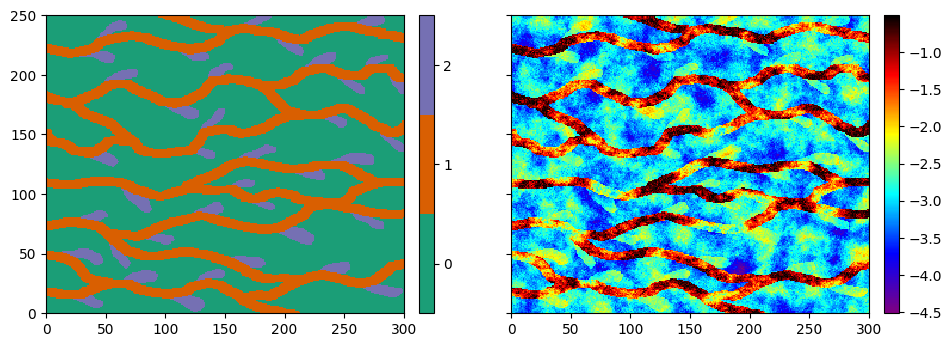

In [3]:
# Plotting
facies = ti.get_unique_one_var(0) # facies = [0., 1., 2.], values taken by the 1st variable
facies_col = ['#1b9e77', "#d95f02", '#7570b3'] # color for facies

# Color settings - 2nd variable (index 1)
vcont_min = ti.vmin()[1] # min TI value of the 2nd variable
vcont_max = ti.vmax()[1] # max TI value of the 2nd variable
vcont_cmap = gn.customcolors.cmap2 # choose a color map for the 2nd variable

# Display
plt.subplots(1, 2, figsize=(11,5), sharey=True) # 1 x 2 sub-plots

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti, iv=0, categ=True, categVal=facies, categCol=facies_col)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti, iv=1, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max)

plt.show()

## Define the simulation grid

In [4]:
nx, ny, nz = 100, 100, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Hard data
Define some hard data (point set). Note that some points can have only one variable uninformed (`numpy.nan`).

In [5]:
npt = 5 # number of points
nv = 5   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'facies', 'vcont'] # list of variable names
v = np.array([
    [ 10.5,  40.5, 0.5,  1,      -1.2], # x, y, z, facies, vcont: 1st point
    [ 50.5,  35.5, 0.5,  np.nan, -0.8], # ...
    [ 90.5,  48.5, 0.5,  1,      np.nan],
    [ 75.5,  50.5, 0.5,  0,      -4.0],
    [ 20.5,  80.5, 0.5,  2,      -2.0]    
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

Plot the hard data points in the simulation grid.

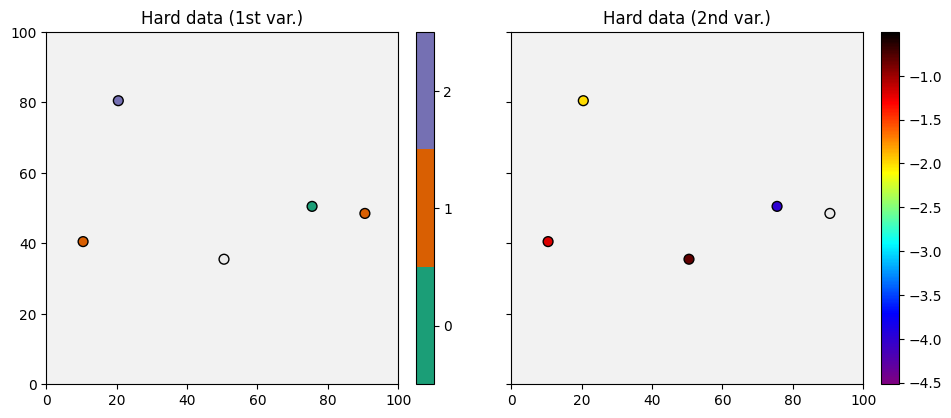

In [6]:
# Get the colors for hard data points according to their values and color settings used for the TI
hd_facies_col = gn.imgplot.get_colors_from_values(hd.val[3], categ=True, categVal=facies, categCol=facies_col)
hd_vcont_col = gn.imgplot.get_colors_from_values(hd.val[4], cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max)

# Set an image with simulation grid geometry defined above, and no variable
im_empty = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Plot
plt.subplots(1, 2, figsize=(11,5), sharey=True) # 1 x 2 sub-plots

plt.subplot(1,2,1)
# 1st variable (facies); plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, categ=True, categVal=facies, categCol=facies_col)
# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_facies_col, edgecolors='black', linewidths=1)
plt.title('Hard data (1st var.)')

plt.subplot(1,2,2)
# 1st variable (facies); plot empty simulation grid and specify colors
gn.imgplot.drawImage2D(im_empty, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max)
# Add hard data points
plt.scatter(hd.x(), hd.y(), marker='o', s=50, color=hd_vcont_col, edgecolors='black', linewidths=1)
plt.title('Hard data (2nd var.)')

plt.show()

Some conditioning data points are uninformed for the 1st or 2nd variable (in gray in the plot above).

Get the index of conditioning data points where the value is known, for each variable.

In [7]:
hd_facies_index = np.where(~np.isnan(hd.val[3]))[0]
hd_vcont_index = np.where(~np.isnan(hd.val[4]))[0]

## Set up the input parameters

> **Reminder:** variable names for the hard data (in `hd.varname`) and for the simulated variables (`varname` below) should correspond (otherwise, the hard data will be ignored).

Here you can set `nreal` greater than `5` (for example `20`) if you are working locally

In [8]:
nreal = 5
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['facies', 'vcont'], # number of variable(s), name of the variable(s)
    TI=ti,
    dataPointSet=hd,
    distanceType=['categorical', 'continuous'], # distance type for each variable
    nneighboringNode=[12, 12],      # max. number of neighbors (for the patterns), for each variable
    distanceThreshold=[.02,.02],    # acceptation threshold (for distance between patterns), for each variable
    maxScanFraction=0.1,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

## Run the simulation

In [9]:
deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 11 thread(s)]
DeeSse run complete


## Retrieve the results (and display)

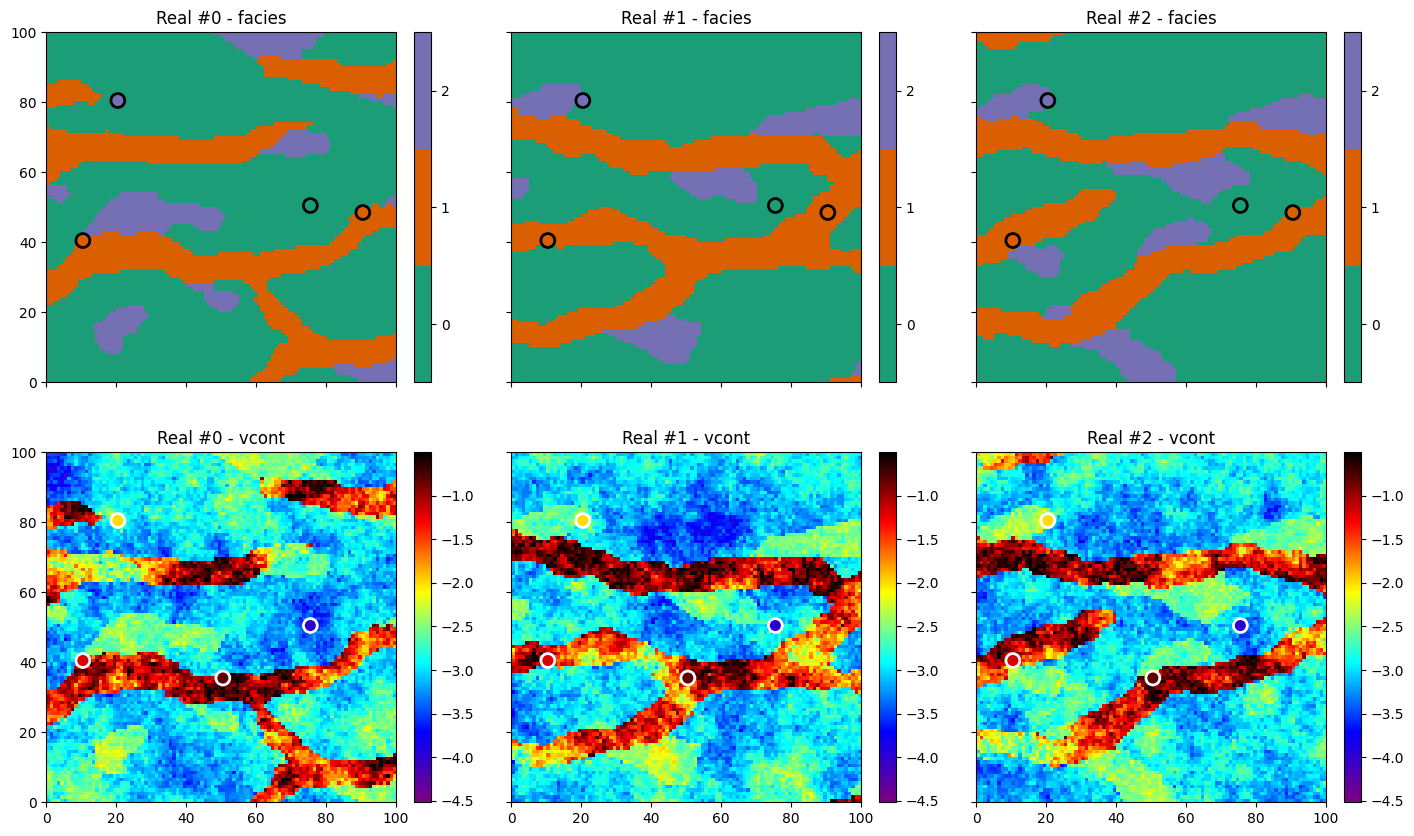

In [10]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True) # 2 x 3 sub-plots

# ... plot the 1st variable of the three first realizations
iv = 0
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, categ=True, categVal=facies, categCol=facies_col, 
                           title=f'Real #{i} - {deesse_input.varname[iv]}')
    plt.scatter(hd.x()[hd_facies_index], hd.y()[hd_facies_index], marker='o', s=100, 
                color=hd_facies_col[hd_facies_index], edgecolors='black', linewidths=2) # add hard data points
                                                                                        # (known values only)

# ... plot the 2nd variable of the three first realizations
iv = 1
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max, 
                           title=f'Real #{i} - {deesse_input.varname[iv]}')
    plt.scatter(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], marker='o', s=100, 
                color=hd_vcont_col[hd_vcont_index], edgecolors='white', linewidths=2) # add hard data points
                                                                                      # (known values only)

plt.show()

## Do some statistics on the realizations

In [11]:
# Do statistics for the 1st variable over all the realizations
# ... gather the nreal realizations of 1st variable into one image
all_sim0 = gn.img.gatherImages(sim, varInd=0) # all_sim is one image with nreal variables (all 1st variables)
# ... compute the pixel-wise proportion for the given categories
all_sim0_stats = gn.img.imageCategProp(all_sim0, facies)

# Do statistics for the 2nd variable over all the realizations
# ... gather the nreal realizations of 2nd variable into one image
all_sim1 = gn.img.gatherImages(sim, varInd=1) # all_sim is one image with nreal variables (all 2nd variables)
# ... compute the pixel-wise mean and standard deviation
all_sim1_mean = gn.img.imageContStat(all_sim1, 'mean')
all_sim1_std = gn.img.imageContStat(all_sim1, 'std')

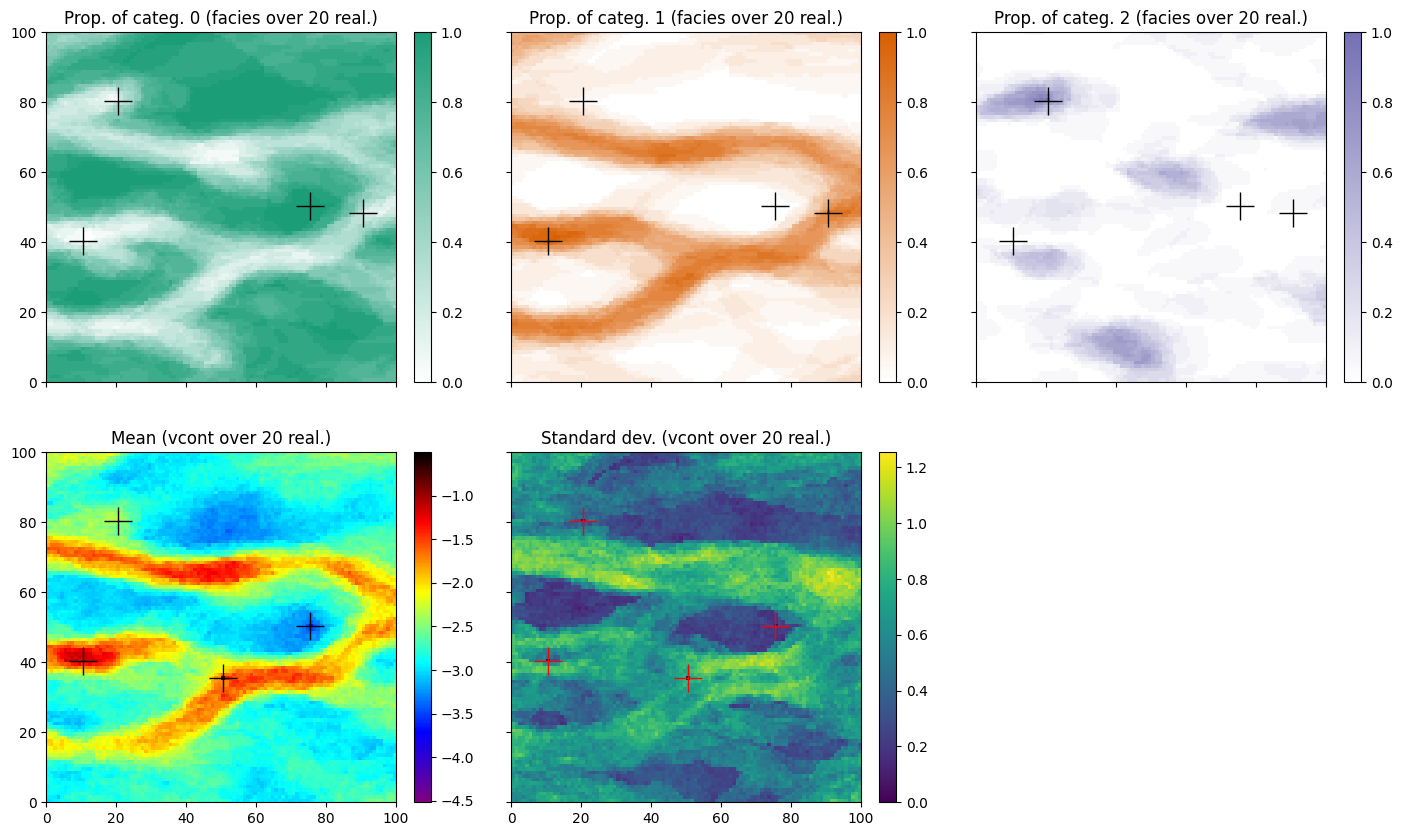

In [12]:
# Display
prop_col=facies_col # colors for the proportion maps
prop_cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# proportion map - facies (1st var.)
plt.subplots(2, 3, figsize=(17,10), sharex=True, sharey=True) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim0_stats, iv=i, cmap=prop_cmap[i],
        title=f'Prop. of categ. {i} ({deesse_input.varname[0]} over {nreal} real.)')
    # add hard data points (with known values)
    plt.plot(hd.x()[hd_facies_index], hd.y()[hd_facies_index], '+', markersize=20, c='black') 
    

# mean map - vcont (2nd var.)
plt.subplot(2,3,4) # select next sub-plot
gn.imgplot.drawImage2D(all_sim1_mean, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max,
                       title=f'Mean ({deesse_input.varname[1]} over {nreal} real.)')
# add hard data points (with known values)
plt.plot(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], '+', markersize=20, c='k')

# standard deviation map - vcont (2nd var.)
plt.subplot(2,3,5) # select 2nd sub-plot
gn.imgplot.drawImage2D(all_sim1_std, 
                       title=f'Standard dev. ({deesse_input.varname[1]} over {nreal} real.)')
# add hard data points (with known values)
plt.plot(hd.x()[hd_vcont_index], hd.y()[hd_vcont_index], '+', markersize=20, c='red')


plt.subplot(2,3,6) # select 2nd sub-plot
plt.axis('off') # no plot

plt.show()